In [83]:
import matplotlib.pyplot as plt  # Plotting library
import numpy as np
import xarray as xr 
import cmaps as cmaps

obnd = xr.open_dataset(r"C:\Users\deela\Downloads\251028H1_1349_vert_outbound.nc")
ibnd = xr.open_dataset(r"C:\Users\deela\Downloads\251028H1_1349_vert_inbound.nc")

In [84]:
obnd['radius'] = obnd['radius'] * -1
obnd['Radial_wind'] = obnd['Radial_wind'] * -1

print(obnd)

<xarray.Dataset> Size: 412kB
Dimensions:          (time: 1, height: 121, heading: 1, radius: 167)
Coordinates:
  * time             (time) float32 4B 4.975e+04
  * height           (height) float32 484B 0.0 0.15 0.3 0.45 ... 17.7 17.85 18.0
  * heading          (heading) float32 4B 15.0
  * radius           (radius) float32 668B -1.5 -3.0 -4.5 ... -249.0 -250.5
Data variables: (12/15)
    azimuth          (radius) float32 668B ...
    altitude         (radius) float32 668B ...
    latitude         (radius) float32 668B ...
    longitude        (radius) float32 668B ...
    seconds          (radius) float32 668B ...
    u air            (radius) float32 668B ...
    ...               ...
    ws air           (radius) float32 668B ...
    Radial_wind      (radius, heading, height, time) float32 81kB nan ... nan
    Tangential_Wind  (radius, heading, height, time) float32 81kB ...
    Vertical_wind    (radius, heading, height, time) float32 81kB ...
    Wind_Speed       (radius, heading, 

In [97]:
data = xr.concat([obnd, ibnd], dim = 'radius')
print(list(data.variables))

['azimuth', 'altitude', 'latitude', 'longitude', 'seconds', 'u air', 'v air', 'w air', 'vgw air', 'ws air', 'Radial_wind', 'Tangential_Wind', 'Vertical_wind', 'Wind_Speed', 'REFLECTIVITY', 'time', 'height', 'heading', 'radius']


In [134]:
def compGrad(uDat, vDat, xC, yC):
    x, y = np.meshgrid(xC, yC, indexing='ij')
    
    dx = np.gradient(xC)[:, None]     
    dy = np.gradient(yC)[None, :]    

    du_dy, du_dx = np.gradient(uDat) 
    dv_dy, dv_dx = np.gradient(vDat)

    fxx = du_dx / dx
    fxy = du_dy / dy
    fyx = dv_dx / dx
    fyy = dv_dy / dy

    vort = fyx - fxy
    div = fxx + fyy

    return vort, div

(334, 121)
183.05292


C:\Users\deela\AppData\Local\Temp\ipykernel_3344\3529351345.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(tang.radius, tang.height, tang.T * 1.94384, vmin = 0, vmax = 200, cmap = cmaps.wind3())


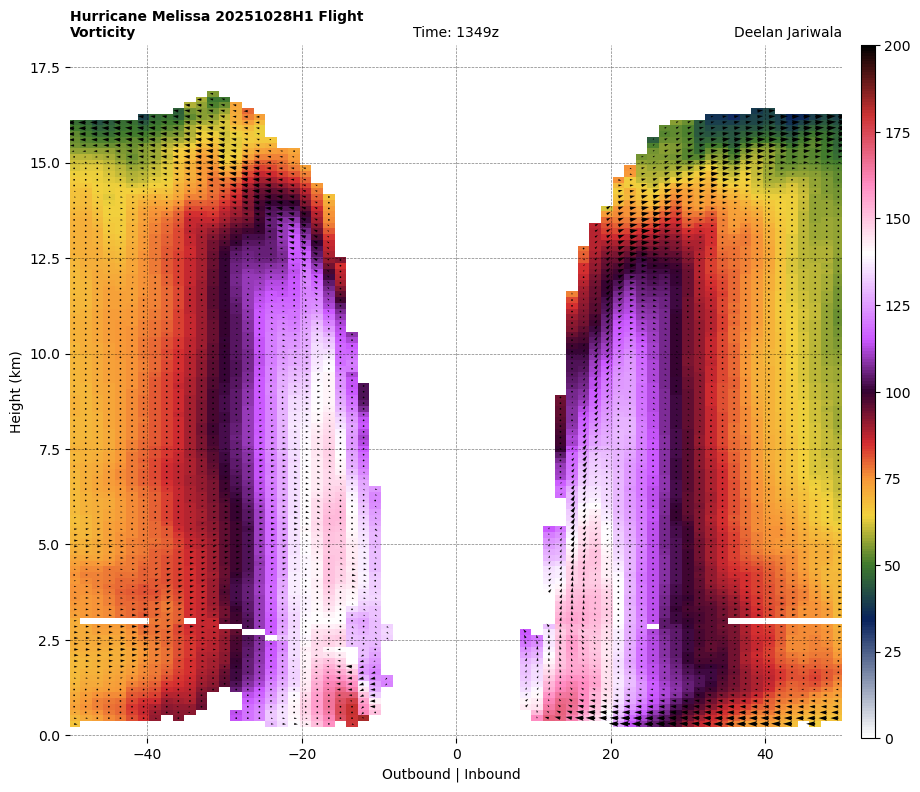

In [296]:
tang = data['Tangential_Wind'].squeeze()
radi = data['Radial_wind'].squeeze()
vvel = data['Vertical_wind'].squeeze()
refl = data['REFLECTIVITY'].squeeze() 

fig = plt.figure(figsize = (12, 9))
ax = plt.axes()
ax.set_frame_on(False)
ax.set_xlim(-50, 50)
# ax.set_ylim(0, 3)
ax.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax.set_xlabel('Outbound | Inbound  ')
ax.set_ylabel('Height (km)')

vort, div = compGrad(radi, vvel, tang.radius, tang.height)
print(div.shape)

c = ax.pcolormesh(tang.radius, tang.height, tang.T * 1.94384, vmin = 0, vmax = 200, cmap = cmaps.wind3())    

radius = radi.radius.values
height = vvel.height.values

X, Y = np.meshgrid(radius, height, indexing = 'ij')
ax.quiver(X, Y, radi, vvel)#, color='black', density=1)
# ax.streamplot(radius, height, radi, vvel, color='black', density=1)
print(np.nanmax(tang.T * 1.94384))
ax.set_title(f'Hurricane Melissa 20251028H1 Flight\nVorticity', fontweight='bold', fontsize=10, loc='left')
ax.set_title(f'Time: 1349z', fontsize = 10, loc = 'center')
ax.set_title('Deelan Jariwala', fontsize=10, loc='right') 

cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02)
# plt.savefig(r"C:\Users\deela\Downloads\melissaProfile.png", dpi = 200, bbox_inches = 'tight')    
plt.show() 

In [302]:
binEdges = np.arange(-10, 55, .5)
heights = refl.height
bins = [[0 for _ in binEdges] for _ in heights]
for i in range(len(binEdges)):
    for j in range(len(heights)):
        temp = refl.sel(height = heights[j]).values
        for k in range(len(temp)):
            try:
                if binEdges[i] < temp[k] < binEdges[i + 1]:
                    bins[j][i] = bins[j][i] + 1
                else:
                    bins[j][i] = bins[j][i] + 0
            except:
                pass

bins = np.array(bins)

(121, 130)


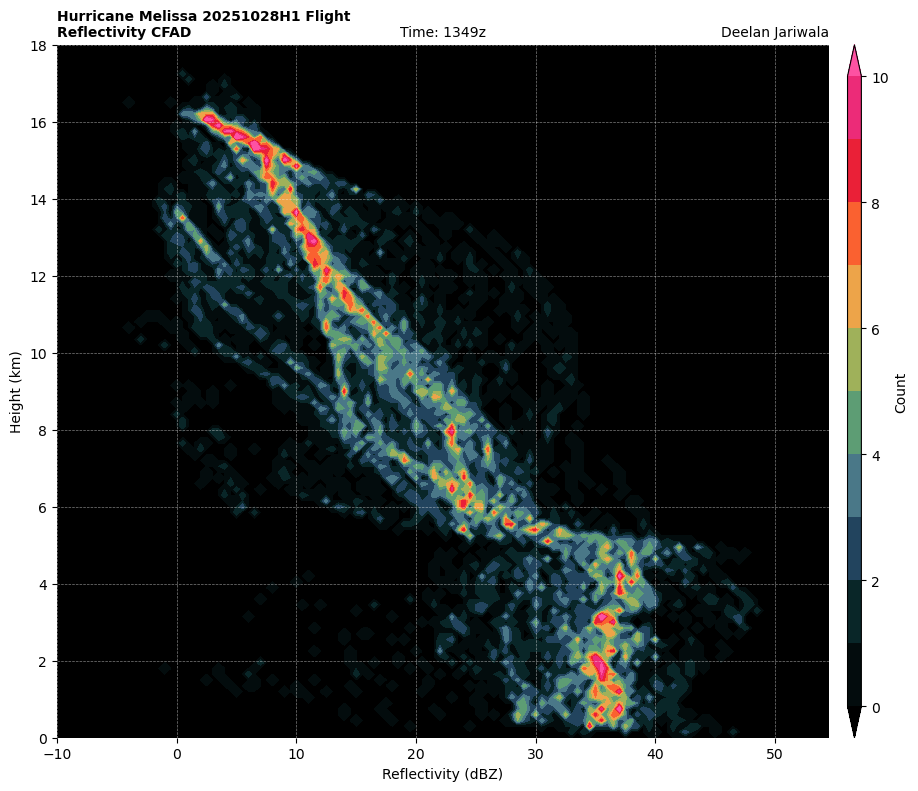

In [325]:
from matplotlib.colors import LogNorm, PowerNorm
from scipy.ndimage import gaussian_filter 

fig = plt.figure(figsize = (12, 9))
ax = plt.axes()
ax.set_frame_on(False)
ax.grid(linestyle = '--', alpha = 0.5, color = 'white', linewidth = 0.5, zorder = 9)
ax.set_xlabel('Reflectivity (dBZ)')
ax.set_ylabel('Height (km)')

bins = np.array(bins)
print(bins.shape)
# heights = np.arange
# plt.ylim(0, 100)
# c = plt.pcolormesh(binEdges, heights, bins, cmap = cmaps.probs4(), vmin = 0, vmax = 5)#, norm=PowerNorm(.5))
c = plt.contourf(binEdges, heights, bins, levels = np.arange(0, 11, 1), extend = 'both', cmap = cmaps.probs4())

ax.set_title(f'Hurricane Melissa 20251028H1 Flight\nReflectivity CFAD', fontweight='bold', fontsize=10, loc='left')
ax.set_title(f'Time: 1349z', fontsize = 10, loc = 'center')
ax.set_title('Deelan Jariwala', fontsize=10, loc='right') 

cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02, label = 'Count')
plt.savefig(r"C:\Users\deela\Downloads\melissaProfileCFAD2.png", dpi = 200, bbox_inches = 'tight')    
plt.show() 

c:\Users\deela\anaconda3\envs\Env5252025\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
C:\Users\deela\AppData\Local\Temp\ipykernel_3344\3764124231.py:19: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(temp, axis = 0), height, linewidth = 2, color = 'black', label = 'Mean')
C:\Users\deela\AppData\Local\Temp\ipykernel_3344\3764124231.py:28: UserWarning: Adding colorbar to a different Figure <Figure size 1200x900 with 43 Axes> than <Figure size 1200x900 with 1 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02, label = 'Count')


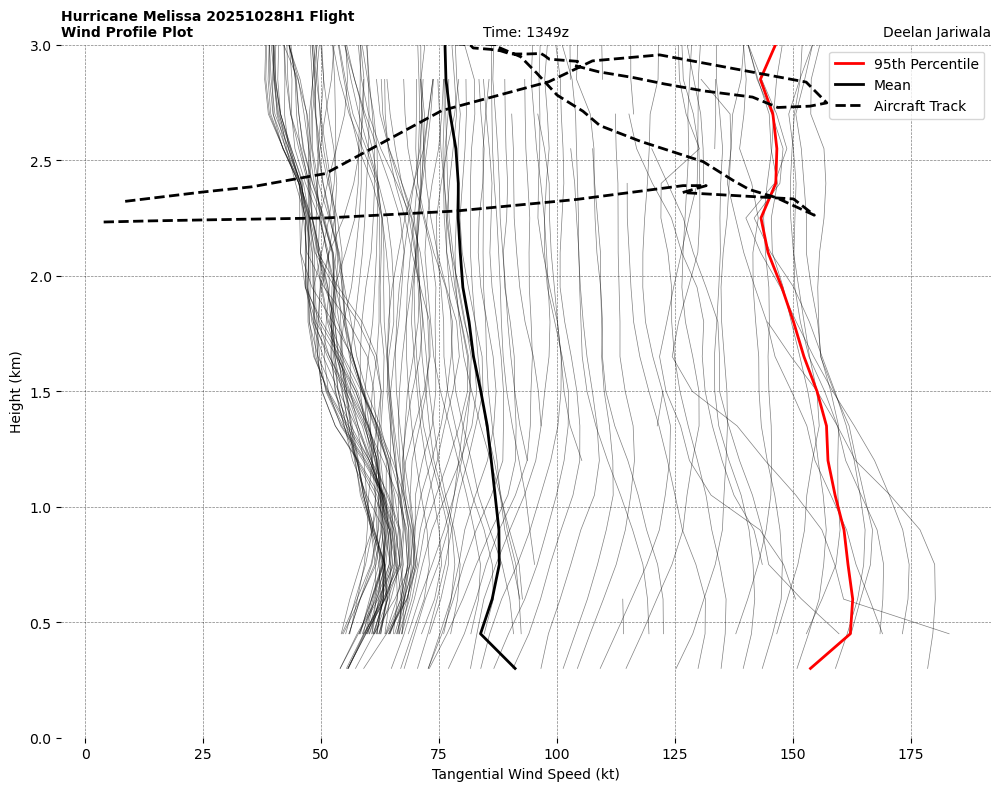

In [295]:
from matplotlib.colors import LogNorm, PowerNorm
from scipy.ndimage import gaussian_filter 

fig = plt.figure(figsize = (12, 9))
ax = plt.axes()
ax.set_frame_on(False)
ax.grid(linestyle = '--', alpha = 0.5, color = 'black', linewidth = 0.5, zorder = 9)
ax.set_xlabel('Tangential Wind Speed (kt)')
ax.set_ylabel('Height (km)')
ax.set_ylim(0, 3)

temp = xr.where(tang * 1.94384 > 0, tang * 1.94384, np.nan)
bljet = temp.sel(height = slice(0, 1))
blHgt = bljet.idxmax('height')
bljet = bljet.max('height')

plt.plot(temp.T, height, linewidth = 0.5, color = 'black', alpha = 0.5)
plt.plot(np.nanpercentile(temp, 95, axis = 0), height, linewidth = 2, color = 'red', label = '95th Percentile')
plt.plot(np.nanmean(temp, axis = 0), height, linewidth = 2, color = 'black', label = 'Mean')
plt.plot(data['ws air'].values * 1.94384, data['altitude'], linewidth = 2, linestyle = '--', color = 'black', label = 'Aircraft Track')

ax.legend()

ax.set_title(f'Hurricane Melissa 20251028H1 Flight\nWind Profile Plot', fontweight='bold', fontsize=10, loc='left')
ax.set_title(f'Time: 1349z', fontsize = 10, loc = 'center')
ax.set_title('Deelan Jariwala', fontsize=10, loc='right') 

cbar = plt.colorbar(c, orientation = 'vertical', aspect = 50, pad = .02, label = 'Count')
plt.savefig(r"C:\Users\deela\Downloads\melissaProfileWinds.png", dpi = 200, bbox_inches = 'tight')    
plt.show() 

In [290]:
print(data['altitude'])

<xarray.DataArray 'altitude' (radius: 334)> Size: 1kB
array([2.2325, 2.2375, 2.2425, 2.25  , 2.28  , 2.33  , 2.39  , 2.39  ,
       2.36  , 2.3325, 2.262 , 2.338 , 2.3733, 2.41  , 2.494 , 2.582 ,
       2.65  , 2.712 , 2.782 , 2.878 , 2.948 , 2.992 , 3.    , 3.002 ,
       3.012 , 3.032 , 3.026 , 3.02  , 3.014 , 3.0267, 3.035 , 3.044 ,
       3.054 , 3.0625, 3.07  ,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan, 